Veuillez uploader votre fichier CSV ou Excel 


Saving SGLD.csv to SGLD (1).csv

Fichier 'SGLD (1).csv' chargé avec succès.

Cinq premières lignes des données préparées :
                Open      High       Low  Close  Log_Return
Date                                                       
2009-07-01   $94.06    $94.06    $94.06   93.84    0.012331
2009-07-02   $92.77    $92.77    $92.77   92.96   -0.009422
2009-07-06   $92.30    $92.30    $92.30   92.26   -0.010030
2009-07-07   $92.20    $93.08    $92.20   92.33    0.000758
2009-07-08   $91.95    $91.95    $91.27   90.99   -0.014620

Nombre total de points de données historiques : 4034

Paramètres de la simulation de Monte Carlo pour 'SGLD (1).csv' :
  Drift (mu) : 0.000337
  Volatilité (sigma) : 0.009947
  Dernier prix historique : 374.25

Exécution de la simulation de Monte Carlo pour 5 Ans...


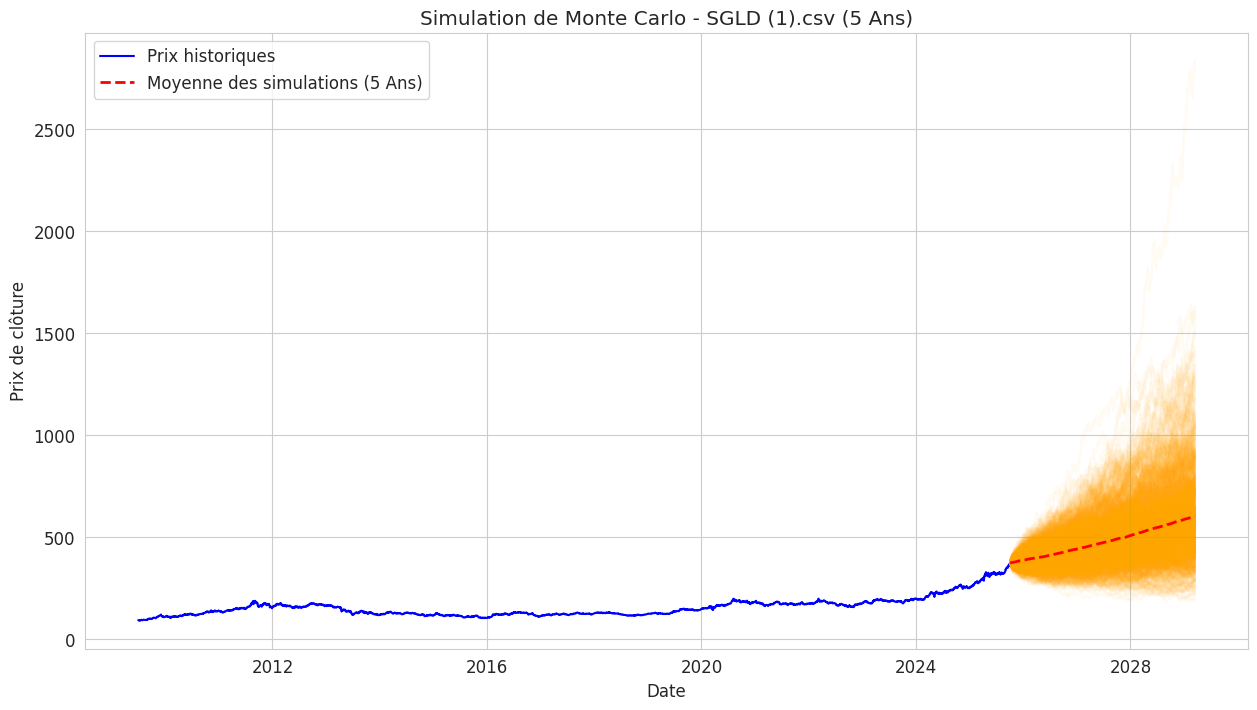


Statistiques de fin de période pour 5 Ans :
  Prix moyen : 602.01
  Écart-type : 229.12
  Intervalle de confiance à 95% : [289.37, 1163.59]

Exécution de la simulation de Monte Carlo pour 10 Ans...


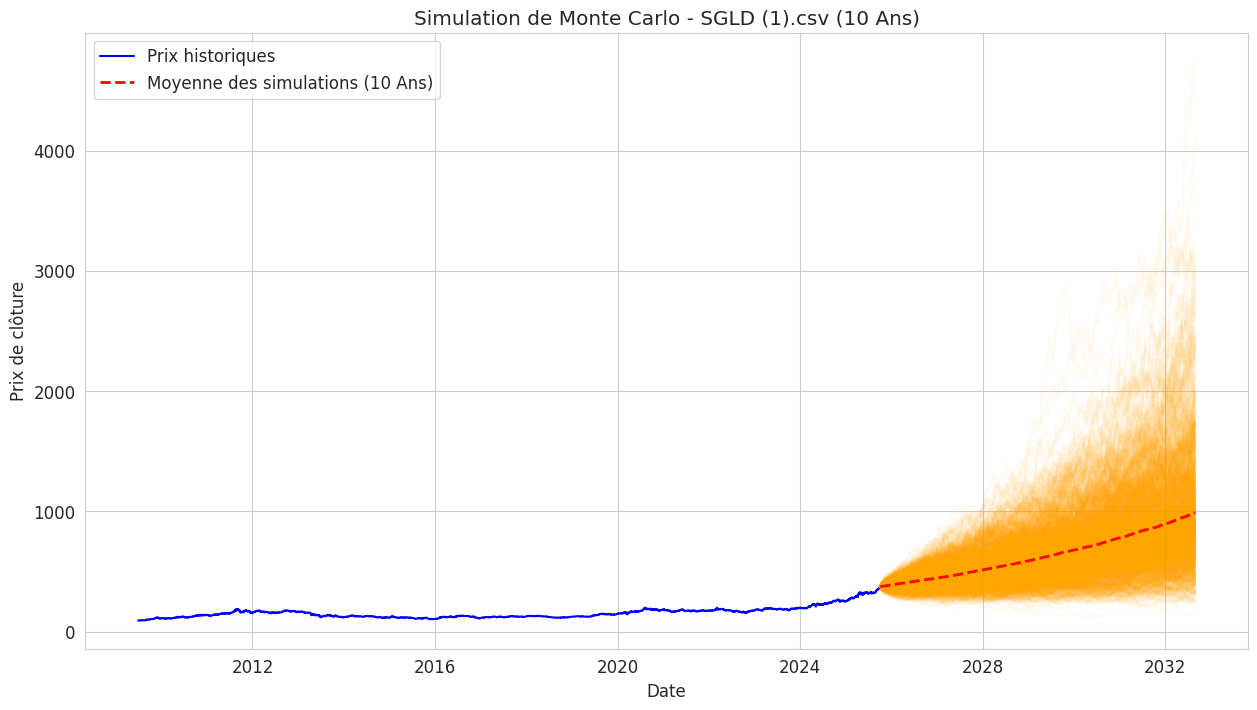


Statistiques de fin de période pour 10 Ans :
  Prix moyen : 989.69
  Écart-type : 509.24
  Intervalle de confiance à 95% : [340.50, 2335.00]

Paramètres de la régression linéaire pour 'SGLD (1).csv' :
  Pente (tendance quotidienne) : 0.0187
  Ordonnée à l'origine : 101.33
  Écart-type des résidus : 35.33


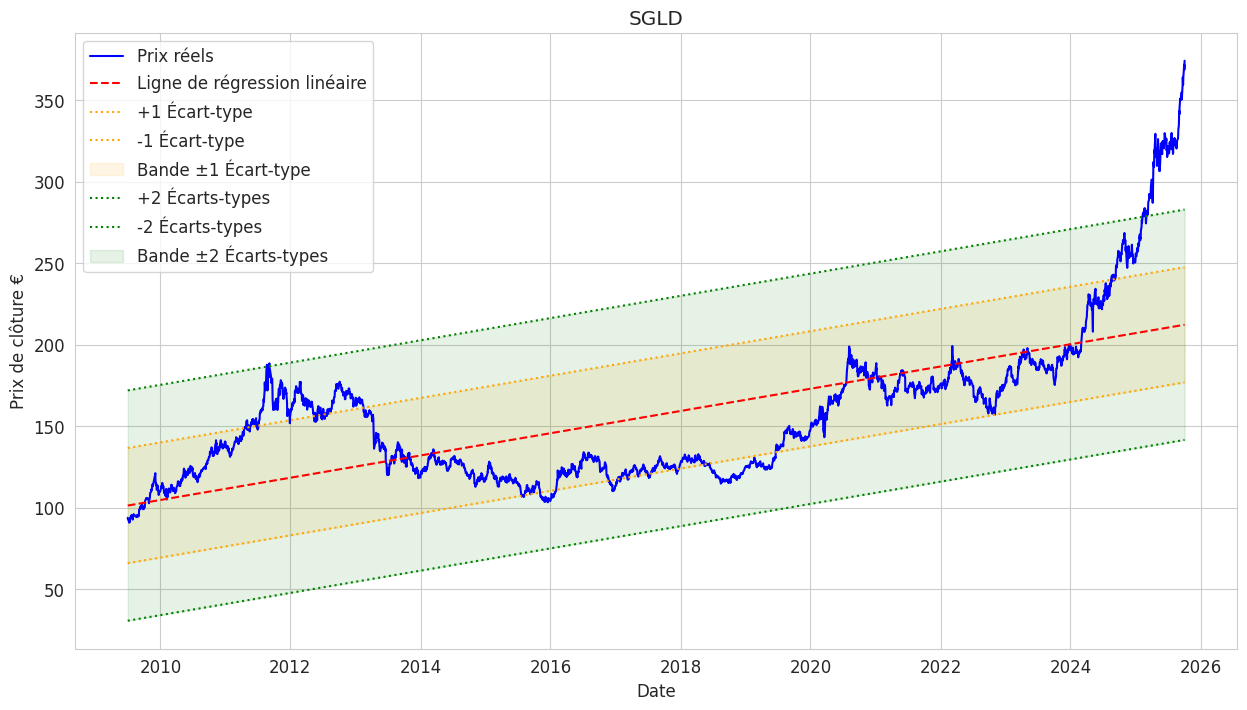


Analyse terminée avec succès.


In [6]:

# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from google.colab import files

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

# --- 2. Fonction pour charger et préparer les données ---
def load_and_prepare_data():
    print("Veuillez uploader votre fichier CSV ou Excel ")
    uploaded = files.upload()
    uploaded_file_name = list(uploaded.keys())[0]

    if uploaded_file_name.endswith('.csv'):
        df = pd.read_csv(uploaded_file_name, parse_dates=['Date'])
    elif uploaded_file_name.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(uploaded_file_name, parse_dates=['Date'])
    else:
        raise ValueError("Format de fichier non supporté. Veuillez uploader un CSV ou Excel.")

    if 'Date' not in df.columns:
        raise ValueError("Le fichier doit contenir une colonne 'Date'.")

    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    if 'Clôture' in df.columns and 'Close' not in df.columns:
        df.rename(columns={'Clôture': 'Close'}, inplace=True)

    if 'Close' not in df.columns:
        raise ValueError("Le fichier doit contenir une colonne 'Close' ou 'Clôture'.")

    df['Close'] = df['Close'].astype(str).str.replace('€', '').str.replace('$', '').str.replace(' ', '').str.replace(',', '.').astype(float)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df.dropna(inplace=True)

    if df.empty:
        raise ValueError("Aucune donnée valide après traitement. Vérifiez le format de votre fichier.")

    print(f"\nFichier '{uploaded_file_name}' chargé avec succès.")
    print("\nCinq premières lignes des données préparées :")
    print(df.head())
    print(f"\nNombre total de points de données historiques : {len(df)}")

    return df, uploaded_file_name

# --- 3. Fonction pour la simulation de Monte Carlo ---
def monte_carlo_simulation(df, file_name):
    mu = df['Log_Return'].mean()
    sigma = df['Log_Return'].std()
    last_price = df['Close'].iloc[-1]
    num_simulations = 1000
    trading_days_per_year = 252

    forecast_periods = {
        '5 Ans': 5 * trading_days_per_year,
        '10 Ans': 10 * trading_days_per_year
    }

    print(f"\nParamètres de la simulation de Monte Carlo pour '{file_name}' :")
    print(f"  Drift (mu) : {mu:.6f}")
    print(f"  Volatilité (sigma) : {sigma:.6f}")
    print(f"  Dernier prix historique : {last_price:.2f}")

    simulated_prices = {}
    for period_name, num_days_forecast in forecast_periods.items():
        print(f"\nExécution de la simulation de Monte Carlo pour {period_name}...")
        price_paths = np.zeros((num_days_forecast, num_simulations))
        price_paths[0] = last_price
        for s in range(num_simulations):
            daily_returns = np.random.normal(loc=mu, scale=sigma, size=num_days_forecast - 1)
            price_multipliers = np.exp(daily_returns)
            for t in range(1, num_days_forecast):
                price_paths[t, s] = price_paths[t-1, s] * price_multipliers[t-1]
        simulated_prices[period_name] = price_paths

        # Tracer les résultats
        plt.figure(figsize=(15, 8))
        plt.plot(df.index, df['Close'], color='blue', label='Prix historiques')
        last_historical_date = df.index[-1]
        forecast_dates = [last_historical_date + timedelta(days=i) for i in range(1, num_days_forecast + 1)]
        for s in range(num_simulations):
            plt.plot(forecast_dates, simulated_prices[period_name][:, s], alpha=0.05, color='orange')
        plt.plot(forecast_dates, np.mean(simulated_prices[period_name], axis=1), color='red', linestyle='--', linewidth=2, label=f'Moyenne des simulations ({period_name})')
        plt.title(f"Simulation de Monte Carlo - {file_name} ({period_name})")
        plt.xlabel('Date')
        plt.ylabel('Prix de clôture')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Statistiques de fin de période
        final_prices = simulated_prices[period_name][-1, :]
        print(f"\nStatistiques de fin de période pour {period_name} :")
        print(f"  Prix moyen : {np.mean(final_prices):.2f}")
        print(f"  Écart-type : {np.std(final_prices):.2f}")
        print(f"  Intervalle de confiance à 95% : [{np.percentile(final_prices, 2.5):.2f}, {np.percentile(final_prices, 97.5):.2f}]")

# --- 4. Fonction pour la régression linéaire avec bandes ---
def linear_regression_with_bands(df, file_name):
    df_reg = df.copy()
    df_reg['Days_Since_Start'] = (df_reg.index - df_reg.index.min()).days
    X = df_reg['Days_Since_Start'].values.reshape(-1, 1)
    y = df_reg['Close'].values

    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    residuals = y - predictions
    std_dev_residuals = np.std(residuals)

    print(f"\nParamètres de la régression linéaire pour '{file_name}' :")
    print(f"  Pente (tendance quotidienne) : {model.coef_[0]:.4f}")
    print(f"  Ordonnée à l'origine : {model.intercept_:.2f}")
    print(f"  Écart-type des résidus : {std_dev_residuals:.2f}")

    # Créer les bandes ±1 et ±2 écarts-types
    upper_band_1 = predictions + 1 * std_dev_residuals
    lower_band_1 = predictions - 1 * std_dev_residuals
    upper_band_2 = predictions + 2 * std_dev_residuals
    lower_band_2 = predictions - 2 * std_dev_residuals

    # Tracer les résultats
    plt.figure(figsize=(15, 8))
    plt.plot(df_reg.index, df_reg['Close'], label='Prix réels', color='blue')
    plt.plot(df_reg.index, predictions, label='Ligne de régression linéaire', color='red', linestyle='--')

    # Bandes ±1 écart-type
    plt.plot(df_reg.index, upper_band_1, label='+1 Écart-type', color='orange', linestyle=':')
    plt.plot(df_reg.index, lower_band_1, label='-1 Écart-type', color='orange', linestyle=':')
    plt.fill_between(df_reg.index, lower_band_1, upper_band_1, color='orange', alpha=0.1, label='Bande ±1 Écart-type')

    # Bandes ±2 écarts-types
    plt.plot(df_reg.index, upper_band_2, label='+2 Écarts-types', color='green', linestyle=':')
    plt.plot(df_reg.index, lower_band_2, label='-2 Écarts-types', color='green', linestyle=':')
    plt.fill_between(df_reg.index, lower_band_2, upper_band_2, color='green', alpha=0.1, label='Bande ±2 Écarts-types')

    plt.title(f"SGLD")
    plt.xlabel('Date')
    plt.ylabel('Prix de clôture €')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 5. Exécution du code ---
if __name__ == "__main__":
    try:
        df, file_name = load_and_prepare_data()
        monte_carlo_simulation(df, file_name)
        linear_regression_with_bands(df, file_name)
        print("\nAnalyse terminée avec succès.")
    except Exception as e:
        print(f"\nUne erreur est survenue : {e}")



  FINANCIAL ANALYSIS TOOL
  Monte Carlo Simulation & Linear Regression

📊 Upload your CSV or Excel file...


Saving SGLD.csv to SGLD (2).csv
✅ Loaded: SGLD (2).csv
📈 Data points: 4034
📅 Period: 2009-07-01 to 2025-10-03

🎲 MONTE CARLO SIMULATION
Drift (μ): 0.000337
Volatility (σ): 0.009947
Current Price: $374.25
Simulations: 1,000

⏱️  Running 5 Years simulation...


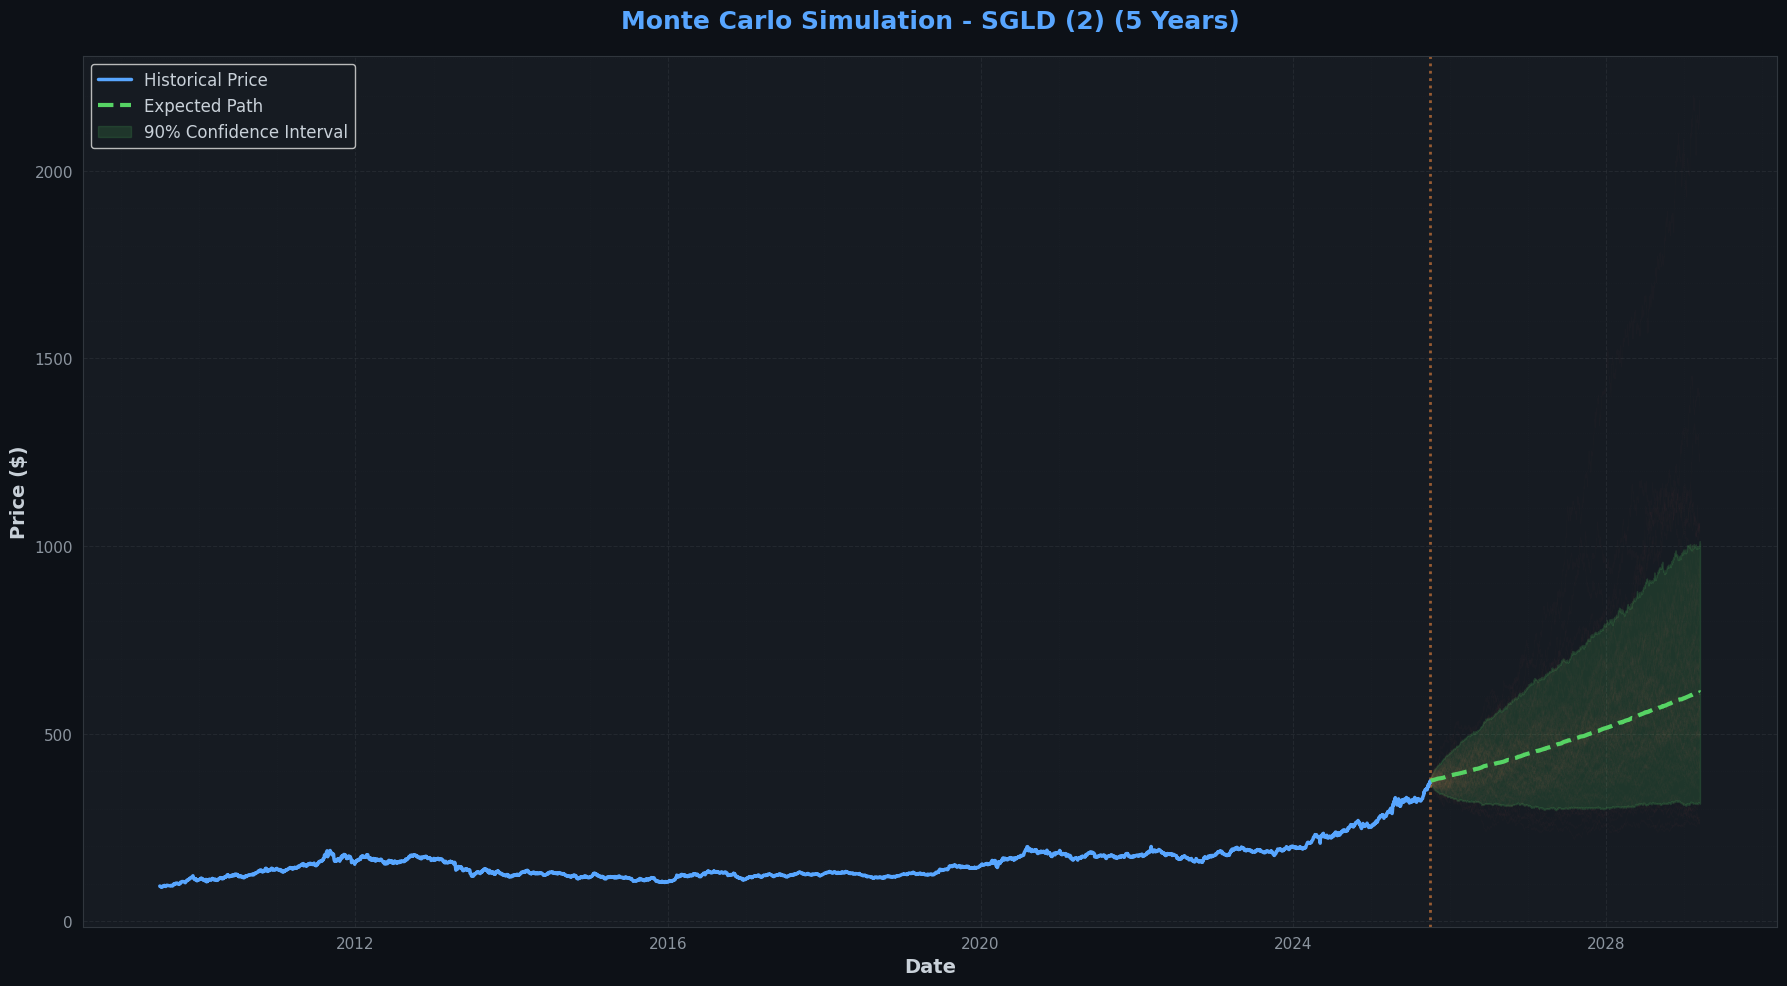


📊 5 Years Forecast Statistics:
──────────────────────────────────────────────────
Expected Final Price: $609.54
Standard Deviation: $223.09
95% Confidence Interval: [$281.30, $1108.26]
Potential Return: 62.87%

⏱️  Running 10 Years simulation...


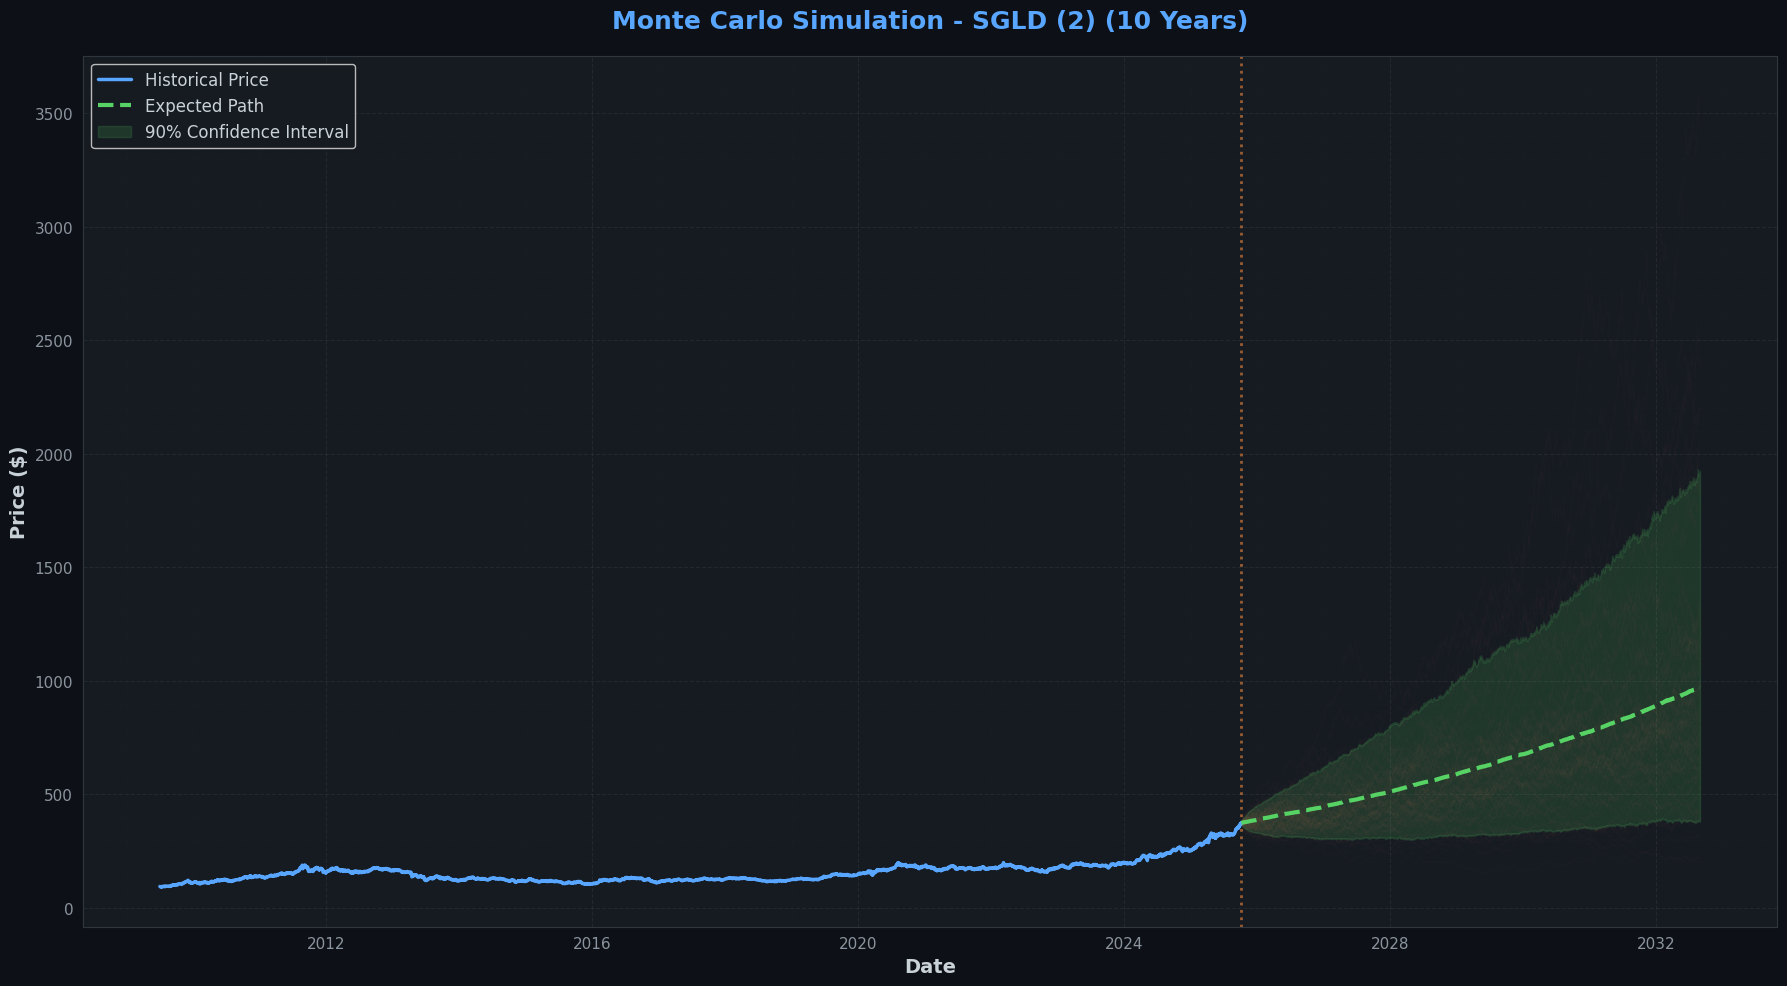


📊 10 Years Forecast Statistics:
──────────────────────────────────────────────────
Expected Final Price: $970.79
Standard Deviation: $500.38
95% Confidence Interval: [$319.33, $2293.84]
Potential Return: 159.40%

📈 LINEAR REGRESSION ANALYSIS
Daily Trend: $0.0187/day
Annualized Trend: $4.71/year
Residual Std Dev: $35.33



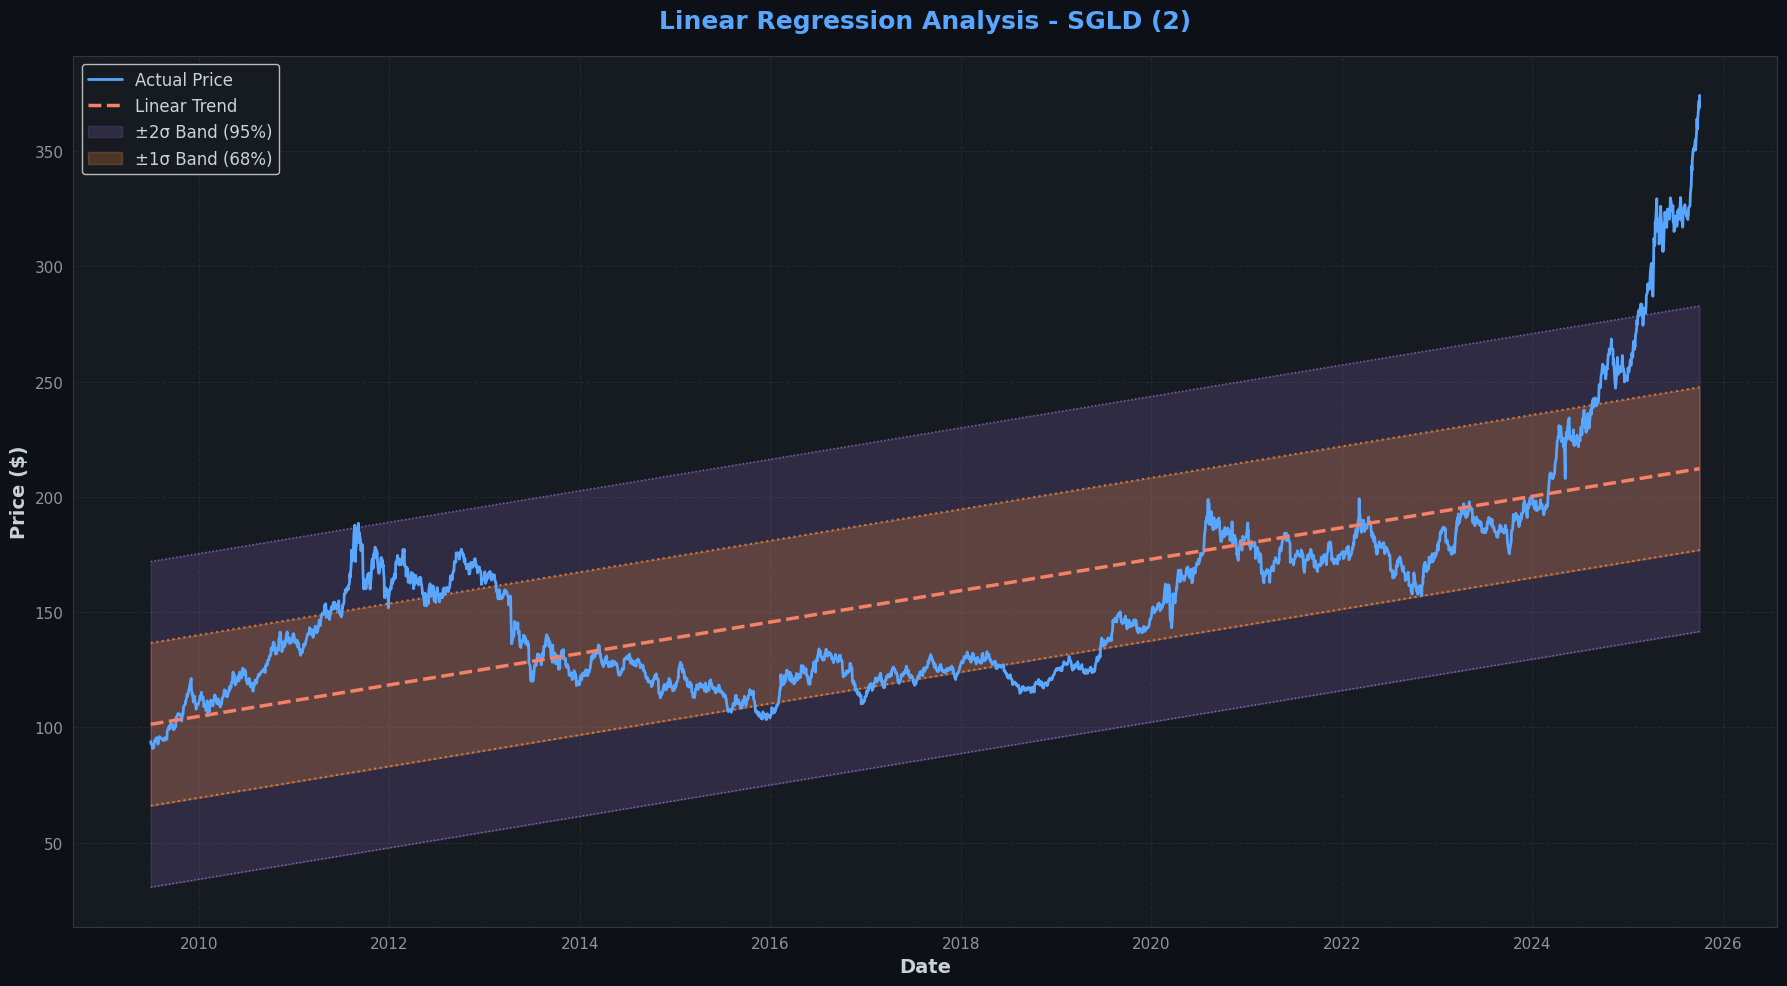


📄 Generating PDF Report...


/tmp/ipython-input-994796961.py:403: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  pdf.savefig(fig, facecolor='#0d1117')
/tmp/ipython-input-994796961.py:403: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans Mono.
  pdf.savefig(fig, facecolor='#0d1117')


✅ Report generated: Financial_Analysis_Report_SGLD (2)_20251006_103456.pdf
📥 Downloading report...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download complete!


✅ Analysis completed successfully!
📄 Report saved: Financial_Analysis_Report_SGLD (2)_20251006_103456.pdf



In [8]:
# ==========================================
# Monte Carlo Simulation & Linear Regression
# Stock Price Analysis Tool
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import timedelta, datetime
from google.colab import files
from matplotlib.backends.backend_pdf import PdfPages
import os

# ==========================================
# CONFIGURATION
# ==========================================

# Dark theme configuration
plt.style.use('dark_background')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#161b22'
plt.rcParams['axes.edgecolor'] = '#30363d'
plt.rcParams['axes.labelcolor'] = '#c9d1d9'
plt.rcParams['xtick.color'] = '#8b949e'
plt.rcParams['ytick.color'] = '#8b949e'
plt.rcParams['text.color'] = '#c9d1d9'
plt.rcParams['grid.color'] = '#30363d'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['font.size'] = 11

# Enable minor grid
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'

# Color scheme
COLORS = {
    'primary': '#58a6ff',
    'secondary': '#f78166',
    'accent': '#56d364',
    'warning': '#f0883e',
    'purple': '#bc8cff',
    'historical': '#58a6ff',
    'simulation': '#f78166',
    'mean': '#56d364',
    'regression': '#f78166',
    'band1': '#f0883e',
    'band2': '#bc8cff'
}

# Report storage
REPORT_DATA = {
    'figures': [],
    'stats': [],
    'file_name': '',
    'analysis_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

# ==========================================
# DATA LOADING & PREPARATION
# ==========================================

def load_and_prepare_data():
    """
    Load and prepare financial data from CSV or Excel file.
    Returns cleaned DataFrame with calculated log returns.
    """
    print("📊 Upload your CSV or Excel file...")
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]

    # Load file
    if file_name.endswith('.csv'):
        df = pd.read_csv(file_name, parse_dates=['Date'])
    elif file_name.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(file_name, parse_dates=['Date'])
    else:
        raise ValueError("Unsupported file format. Please upload CSV or Excel.")

    # Validate and prepare data
    if 'Date' not in df.columns:
        raise ValueError("File must contain a 'Date' column.")

    df = df.sort_values(by='Date')
    df.set_index('Date', inplace=True)

    # Handle French/English column names
    if 'Clôture' in df.columns and 'Close' not in df.columns:
        df.rename(columns={'Clôture': 'Close'}, inplace=True)

    if 'Close' not in df.columns:
        raise ValueError("File must contain a 'Close' or 'Clôture' column.")

    # Clean price data
    df['Close'] = (df['Close'].astype(str)
                   .str.replace('€', '').str.replace('$', '')
                   .str.replace(' ', '').str.replace(',', '.')
                   .astype(float))

    # Calculate log returns
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df.dropna(inplace=True)

    if df.empty:
        raise ValueError("No valid data after processing.")

    print(f"✅ Loaded: {file_name}")
    print(f"📈 Data points: {len(df)}")
    print(f"📅 Period: {df.index.min().date()} to {df.index.max().date()}\n")

    return df, file_name

# ==========================================
# MONTE CARLO SIMULATION
# ==========================================

def monte_carlo_simulation(df, file_name):
    """
    Perform Monte Carlo simulation for stock price forecasting.
    Generates probabilistic price paths using geometric Brownian motion.
    """
    # Calculate parameters
    mu = df['Log_Return'].mean()
    sigma = df['Log_Return'].std()
    last_price = df['Close'].iloc[-1]
    num_simulations = 1000
    trading_days_per_year = 252

    # Forecast horizons
    forecast_periods = {
        '5 Years': 5 * trading_days_per_year,
        '10 Years': 10 * trading_days_per_year
    }

    print("🎲 MONTE CARLO SIMULATION")
    print(f"{'='*50}")
    print(f"Drift (μ): {mu:.6f}")
    print(f"Volatility (σ): {sigma:.6f}")
    print(f"Current Price: ${last_price:.2f}")
    print(f"Simulations: {num_simulations:,}\n")

    for period_name, num_days in forecast_periods.items():
        print(f"⏱️  Running {period_name} simulation...")

        # Initialize price paths
        price_paths = np.zeros((num_days, num_simulations))
        price_paths[0] = last_price

        # Run simulations
        for s in range(num_simulations):
            daily_returns = np.random.normal(mu, sigma, num_days - 1)
            price_multipliers = np.exp(daily_returns)
            for t in range(1, num_days):
                price_paths[t, s] = price_paths[t-1, s] * price_multipliers[t-1]

        # Generate forecast dates
        last_date = df.index[-1]
        forecast_dates = [last_date + timedelta(days=i) for i in range(1, num_days + 1)]

        # Calculate statistics
        final_prices = price_paths[-1, :]
        mean_path = np.mean(price_paths, axis=1)
        percentile_5 = np.percentile(price_paths, 5, axis=1)
        percentile_95 = np.percentile(price_paths, 95, axis=1)

        # Plotting
        fig, ax = plt.subplots(figsize=(18, 10))

        # Historical data
        ax.plot(df.index, df['Close'], color=COLORS['historical'],
                linewidth=2.5, label='Historical Price', zorder=3)

        # Individual simulations (sample)
        sample_size = min(100, num_simulations)
        for s in range(sample_size):
            ax.plot(forecast_dates, price_paths[:, s],
                   color=COLORS['simulation'], alpha=0.02, linewidth=0.5)

        # Mean path and confidence intervals
        ax.plot(forecast_dates, mean_path, color=COLORS['mean'],
                linewidth=3, label=f'Expected Path', zorder=4, linestyle='--')
        ax.fill_between(forecast_dates, percentile_5, percentile_95,
                        color=COLORS['accent'], alpha=0.15,
                        label='90% Confidence Interval', zorder=2)

        # Styling
        ax.set_title(f'Monte Carlo Simulation - {file_name.replace(".csv", "").replace(".xlsx", "")} ({period_name})',
                    fontsize=18, fontweight='bold', pad=20, color=COLORS['primary'])
        ax.set_xlabel('Date', fontsize=14, fontweight='bold')
        ax.set_ylabel('Price ($)', fontsize=14, fontweight='bold')
        ax.legend(loc='upper left', fontsize=12, framealpha=0.9)

        # Enhanced grid
        ax.grid(True, which='major', alpha=0.5, linewidth=0.8, linestyle='--')
        ax.grid(True, which='minor', alpha=0.2, linewidth=0.5, linestyle=':')
        ax.minorticks_on()

        # Add vertical line at forecast start
        ax.axvline(x=last_date, color=COLORS['warning'],
                  linestyle=':', linewidth=2, alpha=0.6, label='Forecast Start')

        plt.tight_layout()

        # Save figure for report
        REPORT_DATA['figures'].append(fig)

        plt.show()

        # Print statistics
        stats_text = f"\n📊 {period_name} Forecast Statistics:\n"
        stats_text += f"{'─'*50}\n"
        stats_text += f"Expected Final Price: ${np.mean(final_prices):.2f}\n"
        stats_text += f"Standard Deviation: ${np.std(final_prices):.2f}\n"
        stats_text += f"95% Confidence Interval: [${np.percentile(final_prices, 2.5):.2f}, ${np.percentile(final_prices, 97.5):.2f}]\n"
        stats_text += f"Potential Return: {((np.mean(final_prices) / last_price - 1) * 100):.2f}%\n"

        print(stats_text)
        REPORT_DATA['stats'].append({
            'type': f'Monte Carlo - {period_name}',
            'text': stats_text
        })

# ==========================================
# LINEAR REGRESSION WITH BANDS
# ==========================================

def linear_regression_with_bands(df, file_name):
    """
    Perform linear regression analysis with confidence bands.
    Shows price trend and deviation patterns.
    """
    print("📈 LINEAR REGRESSION ANALYSIS")
    print(f"{'='*50}")

    df_reg = df.copy()
    df_reg['Days_Since_Start'] = (df_reg.index - df_reg.index.min()).days

    # Fit model
    X = df_reg['Days_Since_Start'].values.reshape(-1, 1)
    y = df_reg['Close'].values

    model = LinearRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    residuals = y - predictions
    std_dev = np.std(residuals)

    print(f"Daily Trend: ${model.coef_[0]:.4f}/day")
    print(f"Annualized Trend: ${model.coef_[0] * 252:.2f}/year")
    print(f"Residual Std Dev: ${std_dev:.2f}\n")

    # Calculate bands
    upper_1std = predictions + 1 * std_dev
    lower_1std = predictions - 1 * std_dev
    upper_2std = predictions + 2 * std_dev
    lower_2std = predictions - 2 * std_dev

    # Plotting
    fig, ax = plt.subplots(figsize=(18, 10))

    # Price data
    ax.plot(df_reg.index, df_reg['Close'], color=COLORS['historical'],
            linewidth=2, label='Actual Price', zorder=3)

    # Regression line
    ax.plot(df_reg.index, predictions, color=COLORS['regression'],
            linewidth=2.5, linestyle='--', label='Linear Trend', zorder=4)

    # ±2 std bands
    ax.fill_between(df_reg.index, lower_2std, upper_2std,
                    color=COLORS['band2'], alpha=0.15,
                    label='±2σ Band (95%)', zorder=1)
    ax.plot(df_reg.index, upper_2std, color=COLORS['band2'],
            linewidth=1, linestyle=':', alpha=0.6)
    ax.plot(df_reg.index, lower_2std, color=COLORS['band2'],
            linewidth=1, linestyle=':', alpha=0.6)

    # ±1 std bands
    ax.fill_between(df_reg.index, lower_1std, upper_1std,
                    color=COLORS['band1'], alpha=0.25,
                    label='±1σ Band (68%)', zorder=2)
    ax.plot(df_reg.index, upper_1std, color=COLORS['band1'],
            linewidth=1.5, linestyle=':', alpha=0.8)
    ax.plot(df_reg.index, lower_1std, color=COLORS['band1'],
            linewidth=1.5, linestyle=':', alpha=0.8)

    # Styling
    ticker = file_name.replace('.csv', '').replace('.xlsx', '').upper()
    ax.set_title(f'Linear Regression Analysis - {ticker}',
                fontsize=18, fontweight='bold', pad=20, color=COLORS['primary'])
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=12, framealpha=0.9)

    # Enhanced grid
    ax.grid(True, which='major', alpha=0.5, linewidth=0.8, linestyle='--')
    ax.grid(True, which='minor', alpha=0.2, linewidth=0.5, linestyle=':')
    ax.minorticks_on()

    plt.tight_layout()

    # Save figure and stats for report
    REPORT_DATA['figures'].append(fig)

    stats_text = f"\n📈 Linear Regression Statistics:\n"
    stats_text += f"{'─'*50}\n"
    stats_text += f"Daily Trend: ${model.coef_[0]:.4f}/day\n"
    stats_text += f"Annualized Trend: ${model.coef_[0] * 252:.2f}/year\n"
    stats_text += f"Residual Std Dev: ${std_dev:.2f}\n"

    REPORT_DATA['stats'].append({
        'type': 'Linear Regression',
        'text': stats_text
    })

    plt.show()

# ==========================================
# REPORT GENERATION
# ==========================================

def generate_report(df):
    """
    Generate a comprehensive PDF report with all analysis results.
    Automatically downloads the report file.
    """
    print("\n📄 Generating PDF Report...")

    # Create output filename
    ticker = REPORT_DATA['file_name'].replace('.csv', '').replace('.xlsx', '').upper()
    output_filename = f"Financial_Analysis_Report_{ticker}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf"

    # Create PDF
    with PdfPages(output_filename) as pdf:
        # Cover page
        fig = plt.figure(figsize=(11, 8.5))
        fig.patch.set_facecolor('#0d1117')
        ax = fig.add_subplot(111)
        ax.axis('off')

        # Title
        title_text = f"FINANCIAL ANALYSIS REPORT\n\n{ticker}"
        ax.text(0.5, 0.7, title_text,
                ha='center', va='center',
                fontsize=32, fontweight='bold',
                color=COLORS['primary'])

        # Metadata
        metadata = f"Analysis Date: {REPORT_DATA['analysis_date']}\n"
        metadata += f"Data Points: {len(df):,}\n"
        metadata += f"Period: {df.index.min().date()} to {df.index.max().date()}\n"
        metadata += f"Current Price: ${df['Close'].iloc[-1]:.2f}"

        ax.text(0.5, 0.4, metadata,
                ha='center', va='center',
                fontsize=14,
                color='#c9d1d9',
                bbox=dict(boxstyle='round,pad=1',
                         facecolor='#161b22',
                         edgecolor=COLORS['primary'],
                         linewidth=2))

        # Footer
        ax.text(0.5, 0.1, "Monte Carlo Simulation & Linear Regression Analysis",
                ha='center', va='center',
                fontsize=12, style='italic',
                color='#8b949e')

        pdf.savefig(fig, facecolor='#0d1117')
        plt.close()

        # Statistics page
        fig = plt.figure(figsize=(11, 8.5))
        fig.patch.set_facecolor('#0d1117')
        ax = fig.add_subplot(111)
        ax.axis('off')

        # Title
        ax.text(0.5, 0.95, "ANALYSIS SUMMARY",
                ha='center', va='top',
                fontsize=24, fontweight='bold',
                color=COLORS['primary'])

        # Statistics
        y_position = 0.85
        for stat in REPORT_DATA['stats']:
            ax.text(0.1, y_position, stat['text'],
                    ha='left', va='top',
                    fontsize=11,
                    color='#c9d1d9',
                    family='monospace',
                    bbox=dict(boxstyle='round,pad=0.8',
                             facecolor='#161b22',
                             edgecolor='#30363d',
                             linewidth=1))
            y_position -= 0.25

        pdf.savefig(fig, facecolor='#0d1117')
        plt.close()

        # Add all figures
        for fig in REPORT_DATA['figures']:
            pdf.savefig(fig, facecolor='#0d1117')

        # Set PDF metadata
        d = pdf.infodict()
        d['Title'] = f'Financial Analysis Report - {ticker}'
        d['Author'] = 'Financial Analysis Tool'
        d['Subject'] = 'Monte Carlo Simulation & Linear Regression'
        d['Keywords'] = 'Finance, Monte Carlo, Linear Regression, Stock Analysis'
        d['CreationDate'] = datetime.now()

    print(f"✅ Report generated: {output_filename}")

    # Download file
    print("📥 Downloading report...")
    files.download(output_filename)
    print("✅ Download complete!\n")

    return output_filename

# ==========================================
# MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    print("\n" + "="*60)
    print("  FINANCIAL ANALYSIS TOOL")
    print("  Monte Carlo Simulation & Linear Regression")
    print("="*60 + "\n")

    try:
        # Load data
        df, file_name = load_and_prepare_data()
        REPORT_DATA['file_name'] = file_name

        # Run analyses
        monte_carlo_simulation(df, file_name)
        linear_regression_with_bands(df, file_name)

        # Generate and download report
        report_file = generate_report(df)

        print("\n" + "="*60)
        print("✅ Analysis completed successfully!")
        print(f"📄 Report saved: {report_file}")
        print("="*60 + "\n")

    except Exception as e:
        print(f"\n❌ Error: {e}\n")